<a href="https://colab.research.google.com/github/VekhovIO/portfolio/blob/main/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Попрактикуемся в применении метода опорных векторов

Цель: построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - `age`
 - `workclass`
 - `fnlwgt`
 - `education`
 - `education-num`
 - `marital-status`
 - `occupation`
 - `relationship`
 - `race`
 - `sex`
 - `capital-gain`
 - `capital-loss`
 - `hours-per-week`

Целевой признак записан в переменной *>50K,<=50K*.

Все исследователи данных знают, что SVM из библиотеки `sklearn` работает крайне медленно, поэтому на практике не могут его применять для решения задач.

В этом ноутбуке мы используем средства библиотеки `sklearn intelex` для ускорения обучения SVM в 600 раз

In [ ]:
# убедимся, что версия python < 3.10
!python --version

Python 3.11.11


In [ ]:
%%capture
!python -m pip install --upgrade pip
!pip install --upgrade scikit-learn-intelex

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [ ]:
import pandas as pd
import numpy as np
import sys
import os
import site

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from matplotlib import pyplot as plt

sys.path.append(os.path.join(os.path.dirname(site.getsitepackages()[0]), "site-packages"))

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/evgpat/edu_stepik_practical_ml/main/datasets/data.adult.csv")

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K


В данном датасете пропущенные значения обозначены как "?".

Найдем все признаки, имеющие пропущенные значения.

In [ ]:
df = df.replace('?', np.nan)
df.isna().sum()

,0
age,0
workclass,929
fnlwgt,0
education,0
education-num,0
marital-status,0
occupation,933
relationship,0
race,0
sex,0


In [ ]:
df.dropna(inplace = True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15347 entries, 0 to 16279
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             15347 non-null  int64 
 1   workclass       15347 non-null  object
 2   fnlwgt          15347 non-null  int64 
 3   education       15347 non-null  object
 4   education-num   15347 non-null  int64 
 5   marital-status  15347 non-null  object
 6   occupation      15347 non-null  object
 7   relationship    15347 non-null  object
 8   race            15347 non-null  object
 9   sex             15347 non-null  object
 10  capital-gain    15347 non-null  int64 
 11  capital-loss    15347 non-null  int64 
 12  hours-per-week  15347 non-null  int64 
 13  >50K,<=50K      15347 non-null  object
dtypes: int64(6), object(8)
memory usage: 1.8+ MB


In [ ]:
y = df['>50K,<=50K']
X = df.drop(columns = ['>50K,<=50K'])
names = X.select_dtypes(include = 'int64').columns
X = X[names]

y = np.where(y == '<=50K', 0, 1)

In [ ]:
np.unique(y)

array([0, 1])

In [ ]:
X.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40


Построим гистограммы для признаков `age`, `fnlwgt`, `capital-gain`.

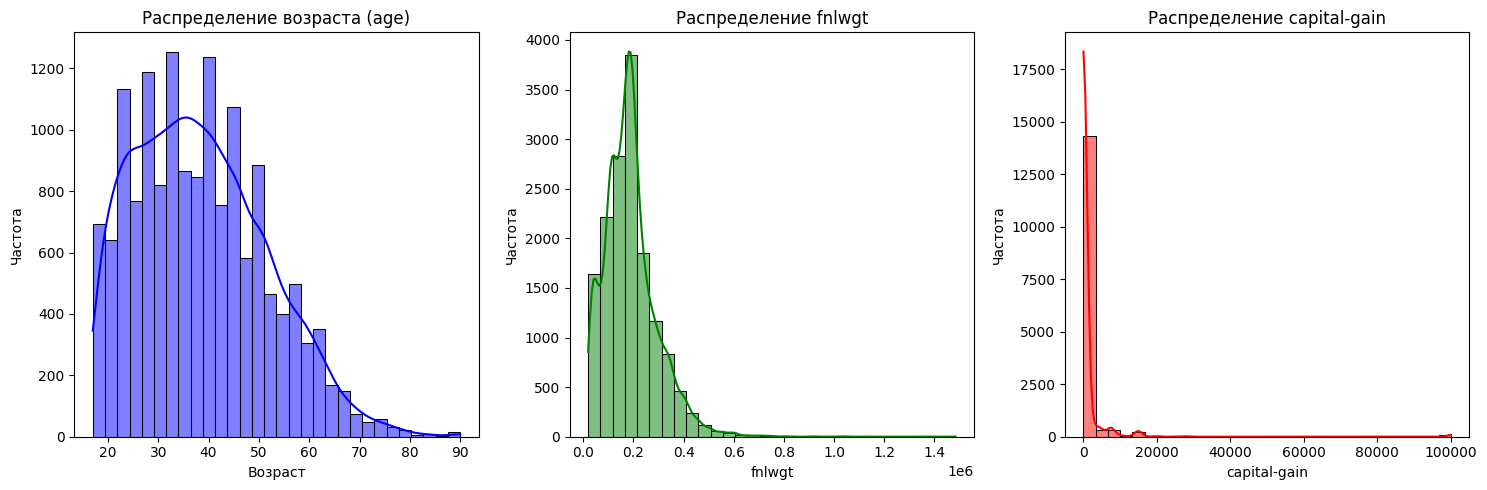

In [ ]:
import seaborn as sns

plt.figure(figsize=(15,5))

plt.subplot(1, 3, 1)
sns.histplot(df['age'], bins=30, kde=True, color='blue')
plt.title('Распределение возраста (age)')
plt.xlabel('Возраст')
plt.ylabel('Частота')


plt.subplot(1, 3, 2)
sns.histplot(df['fnlwgt'], bins=30, kde=True, color='green')
plt.title('Распределение fnlwgt')
plt.xlabel('fnlwgt')
plt.ylabel('Частота')


plt.subplot(1, 3, 3)
sns.histplot(df['capital-gain'], bins=30, kde=True, color='red')
plt.title('Распределение capital-gain')
plt.xlabel('capital-gain')
plt.ylabel('Частота')


plt.tight_layout()  # Чтобы графики не перекрывались
plt.show()

Масштабируем все вещественные признаки

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(X)

Xочется оценить качество модели без привязки к конкретному разбиению на train-test. Для этого все обучающие данные разбиваются на несколько равных блоков (фолдов), и затем модель обучается несколько раз:
* первый раз - на всех блоках, кроме 1-го, а качество оценивается на 1-м блоке
* второй раз - на всех блоках, кроме 2-го, а качество оценивается на 2-м блоке и так далее
Для оценки качества модели полученные значения метрик на тестовых блоках усредняются - это называется *k-fold кросс-валидацией*.

Обучим по кросс-валидации c **тремя** фолдами и метрикой **roc_auc** алгоритмы:
*  LogisticRegression
*  SVC(kernel='linear')

Остальные параметры оставим по умолчанию.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

cross_val_score(LogisticRegression(), X, y, cv=3, scoring='roc_auc', verbose=2).mean()

[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


np.float64(0.825026286490548)

In [ ]:
cross_val_score(SVC(kernel = 'linear'), X, y, cv = 3, scoring = 'roc_auc', verbose = 2).mean()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[CV] END .................................................... total time=   5.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END .................................................... total time=   5.2s
[CV] END .................................................... total time=   3.0s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


np.float64(0.8075427740991511)

Теперь посмотрим как влияет подбор гиперпараметров на качество предсказания моделей. Сейчас и далее будем рассматривать два алгоритма:
 - Logistic Regression
 - SVC (Support Vector Classifier)

У обоих алгоритмов будем оптимизировать гиперпараметр С, а у SVC - ещё гиперпараметр kernel.

*  Ищем C в диапазоне от 0.01 до 10.01 с шагом 0.25
*  Перебираем ядра из списка ['rbf','poly','sigmoid','linear']

Для подбора гиперпараметров воспользуемся перебором по сетке, который реализован в классе GridSearchCV.

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'C' : [1, 2, 3]} # задаем словарь параметров и список перебираемых значений - в данном случае ищем C из списка [1,2,3]

gs = GridSearchCV(LogisticRegression(), params, cv=3, scoring='roc_auc')

gs.fit(X, y)

print(gs.best_score_)
print(gs.best_params_)

0.825026286490548
{'C': 1}


In [ ]:
params = {'kernel': ['linear', 'rbf', 'poly']}

gs = GridSearchCV(SVC(), params, cv = 3, scoring = 'roc_auc')

gs.fit(X, y)

print(gs.best_score_)
print(gs.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

0.8075427740991511
{'kernel': 'linear'}


In [ ]:
params = {'C': np.arange(0.01, 2.01, 0.25)}

gs = GridSearchCV(SVC(kernel = 'linear'), params, cv = 3, scoring = 'roc_auc')

gs.fit(X, y)

print(gs.best_score_)
print(gs.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

0.8117119347552277
{'C': np.float64(0.01)}


Преобразуем все категориальные признаки (исходной матрицы df) с помощью метода one-hot-encoding

In [ ]:
X_old = df.drop('>50K,<=50K', axis=1)

X_new = pd.get_dummies(X_old, drop_first = True)
X_new.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,34,284843,9,594,0,60,True,False,False,False,...,True,False,False,False,False,False,True,False,False,True
1,40,190290,10,0,0,40,False,True,False,False,...,True,False,False,False,False,False,False,False,True,True
2,36,177858,13,0,0,40,True,False,False,False,...,False,False,True,False,False,False,False,False,True,True
3,22,184756,10,0,0,30,False,True,False,False,...,False,False,True,False,False,False,False,False,True,False
4,47,149700,13,15024,0,40,False,True,False,False,...,False,False,False,False,False,False,False,False,True,True


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_new)
X_new = pd.DataFrame(scaler.transform(X_new), columns=X_new.columns)

In [ ]:
cross_val_score(LogisticRegression(C = 1), X_new, y , cv = 3, scoring = 'roc_auc', verbose=2).mean()

[CV] END .................................................... total time=   0.1s


/usr/local/lib/python3.11/dist-packages/daal4py/sklearn/linear_model/logistic_path.py:627: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/daal4py/sklearn/linear_model/logistic_path.py:627: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.1s


/usr/local/lib/python3.11/dist-packages/daal4py/sklearn/linear_model/logistic_path.py:627: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


np.float64(0.9022337868320416)

In [ ]:
cross_val_score(SVC(C = 0.01, kernel = 'linear'), X_new, y , cv = 3, scoring = 'roc_auc', verbose = 2).mean()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

[CV] END .................................................... total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[CV] END .................................................... total time=   1.4s
[CV] END .................................................... total time=   1.4s


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


np.float64(0.8981757431515147)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size = 0.25, random_state = 42)

#model = SVC(C = 0.01, kernel = 'linear')
model = LogisticRegression(C = 1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
roc_auc = roc_auc_score(y_test, y_pred)

print(roc_auc)

0.7668492353189088


/usr/local/lib/python3.11/dist-packages/daal4py/sklearn/linear_model/logistic_path.py:627: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


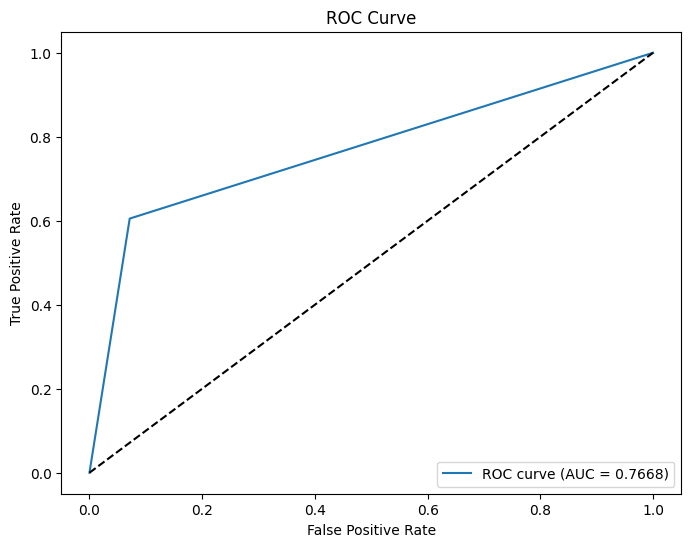

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()